# EEG Seizure Detection: Model Evaluation

This notebook evaluates the performance of the best-trained **1D-CNN + LSTM** model on a held-out clinical test set.

### Objectives:
1. **Inference**: Run the model on subjects never seen during training or validation.
2. **Confusion Matrix**: Visualize prediction accuracy and specific error types (FP/FN).
3. **Clinical Metrics**: Calculate Sensitivity, Specificity, and False Positive Rate per hour (FPR/h).
4. **Performance Interpretation**: Compare results against clinical requirements.

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

# Add src to path
sys.path.append(str(Path(os.getcwd()).parent))

from src.models.cnn_lstm import CNN_LSTM_Classifier
from src.data.dataset import EEGDataset, build_segments_index
from src.utils.config import load_config
from evaluate import run_inference, plot_confusion_matrix, print_thesis_report

# Plotting config
%matplotlib inline
sns.set_style("whitegrid")

## 1. Load Configuration & Best Model

We load the `best_model.pth` checkpoint and prepare the testing subjects.

In [2]:
cfg = load_config("../config.yaml")
raw_test_subjects = cfg.evaluation.test_subjects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt_path = Path("../") / cfg.training.checkpoint_dir / "best_model.pth"

print(f"Target Test Subjects: {raw_test_subjects}")
print(f"Device: {device}")

model = CNN_LSTM_Classifier(
    num_channels=cfg.model.num_channels,
    sequence_length=cfg.model.sequence_length,
    num_classes=cfg.model.num_classes,
    cnn_channels=cfg.model.cnn_channels,
    kernel_size=cfg.model.kernel_size,
    lstm_hidden_size=cfg.model.lstm_hidden_size,
    lstm_num_layers=cfg.model.lstm_num_layers,
    dropout_rate=cfg.model.dropout_rate,
).to(device)

checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")

Target Test Subjects: ['chb19', 'chb20', 'chb21', 'chb22', 'chb23', 'chb24']
Device: cuda
Loaded checkpoint from epoch 7


## 2. Prepare Test Data

We ensure test subjects' data is processed, then initialize the dataset and DataLoader.
**Note**: If a subject is missing a summary file (e.g. `chb22`), it will be skipped automatically.

In [3]:
# Ensure test subjects are processed (re-uses cache if exists)
build_segments_index(
    data_dir="../" + cfg.data.raw_dir,
    subjects=raw_test_subjects,
    output_dir="../" + cfg.data.processed_dir,
    window_size_sec=cfg.data.window_size_sec,
    overlap_ratio=cfg.data.overlap_ratio,
    label_threshold=cfg.data.label_threshold,
)

# Filter subjects to only those successfully indexed
proc_path = Path("../") / cfg.data.processed_dir
test_subjects = [s for s in raw_test_subjects if (proc_path / s / "manifest.txt").exists()]

print(f"Successfully Indexed Subjects: {test_subjects}")
if len(test_subjects) < len(raw_test_subjects):
    missing = set(raw_test_subjects) - set(test_subjects)
    print(f"Warning: Some subjects were skipped due to missing data: {missing}")

test_ds = EEGDataset("../" + cfg.data.processed_dir, test_subjects, normalize=True)
test_loader = DataLoader(
    test_ds,
    batch_size=cfg.training.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

print(f"Total Test Segments: {len(test_ds):,}")

00:17:52 [INFO] [chb19] Cache exists, skipping.
00:17:52 [INFO] [chb20] Cache exists, skipping.
00:17:52 [INFO] [chb21] Cache exists, skipping.
00:17:52 [WARNING] [chb22] No summary file, skipping.
00:17:52 [INFO] [chb23] Cache exists, skipping.
00:17:52 [INFO] [chb24] Cache exists, skipping.


Successfully Indexed Subjects: ['chb19', 'chb20', 'chb21', 'chb23', 'chb24']
Total Test Segments: 231,940


## 3. Run Inference & Analyze Performance

We perform a full pass on the test set to collect predictions and ground truth.

Running inference on test set...
[SAVE] Confusion matrix saved: ..\runs\notebook_eval_cm.png


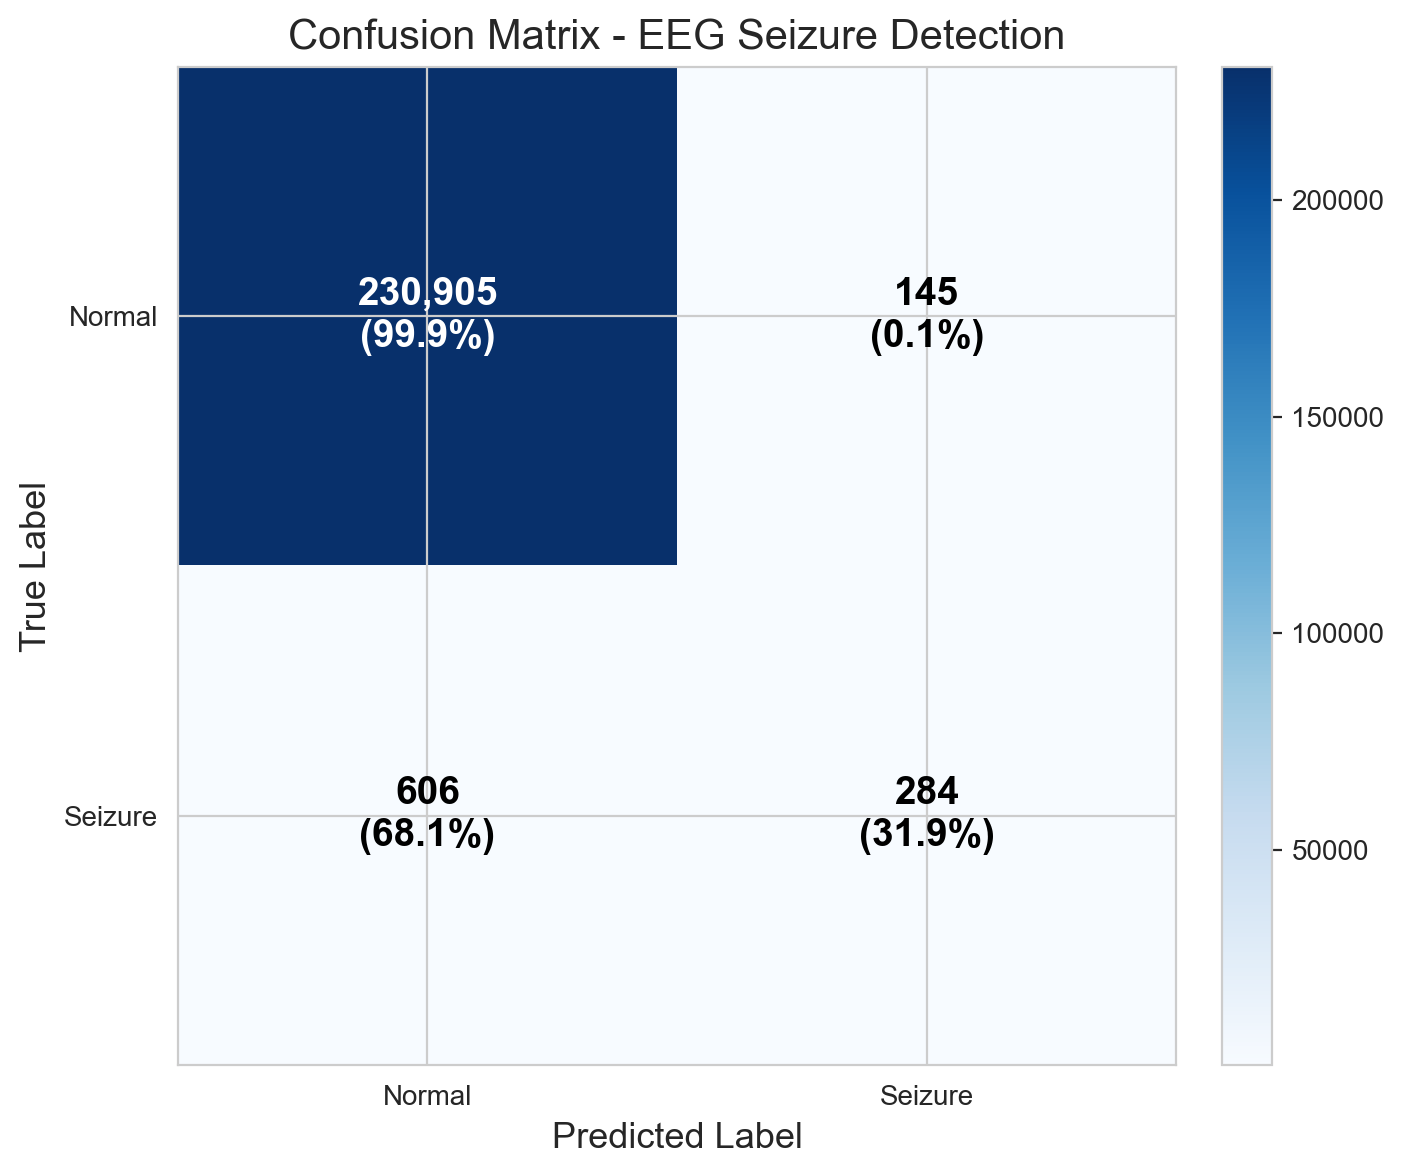

<Figure size 800x600 with 0 Axes>

In [4]:
print("Running inference on test set...")
y_true, y_pred, _ = run_inference(model, test_loader, device)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(y_true, y_pred, Path("../runs/notebook_eval_cm.png"))

# Display the saved image in the notebook
from IPython.display import Image
Image(filename='../runs/notebook_eval_cm.png')

## 4. Clinical Metrics Report

Finally, we generate the clinical summary report suitable for thesis documentation.

In [5]:
print_thesis_report(
    y_true, y_pred, 
    window_sec=cfg.data.window_size_sec, 
    overlap_ratio=cfg.data.overlap_ratio, 
    test_subjects=test_subjects
)


     CLINICAL EVALUATION REPORT -- EEG SEIZURE DETECTION

  Test Subjects:       chb19, chb20, chb21, chb23, chb24
  Total Segments:      231,940
  Seizure Segments:    890
  Normal Segments:     231,050
  Monitored Duration:  128.86 hours

------------------------------------------------------------------------
  CONFUSION MATRIX
------------------------------------------------------------------------
    True Positives  (TP):       284
    True Negatives  (TN):   230,905
    False Positives (FP):       145
    False Negatives (FN):       606

------------------------------------------------------------------------
  CLINICAL METRICS
------------------------------------------------------------------------
    Accuracy:                 99.68%
    Sensitivity (Recall):    0.3191   (seizure detection rate)
    Specificity:             0.9994   (normal rejection rate)
    F1-Score:                0.4306   (harmonic mean)
    False Alarm Rate:        0.0006
    FPR / hour:                